# Exploratory Data Analysis of ChEMBL Dataset

In [50]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import rdkit
import polars.selectors as cs
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
from scipy.stats import pearsonr, spearmanr


print('Libraries imported successfully.')

Libraries imported successfully.


## 1. Load Data

In [51]:
df = pl.read_parquet('processed_data/ChEMBL_processed.parquet')
print('Data loaded successfully.')

Data loaded successfully.


# I. Wstępna Eksploracja Danych

### 1. Załadowanie i pierwszy rzut oka na dane

**Struktura datasetu:**
- **Liczba rekordów:** 1,698,981 wierszy
- **Liczba cech:** 20 kolumn
- **Format:** Polars DataFrame (plik .parquet)

In [52]:
df.head()

activity_id,molregno,canonical_smiles,mw_freebase,alogp,hba,hbd,psa,rtb,aromatic_rings,qed_weighted,standard_value,standard_units,standard_type,standard_relation,pchembl_value,target_chembl_id,target_name,confidence_score,pIC50
i64,i64,str,f64,f64,i64,i64,f64,i64,i64,f64,f64,str,str,str,f64,str,str,i64,f64
4119222,961254,"""Cc1ccc(N2C(=O)CC(Sc3cccs3)C2=O…",303.41,3.48,4,0,37.38,3,2,0.81,2238.7,"""nM""","""Potency""","""=""",5.65,"""CHEMBL3577""","""Aldehyde dehydrogenase 1A1""",9,5.650004
2669244,556566,"""O=C(CC1(CC(=O)NC2C3CC4CC(C3)CC…",408.59,4.58,2,2,58.2,7,1,0.69,19.0,"""nM""","""IC50""","""=""",7.72,"""CHEMBL4235""","""11-beta-hydroxysteroid dehydro…",9,7.721246
4559012,952361,"""Cc1cccc(C)c1NC(=O)C1(N(Cc2ccco…",466.54,3.16,5,3,120.75,7,2,0.54,39810.7,"""nM""","""Potency""","""=""",4.4,"""CHEMBL2093861""","""Menin/Histone-lysine N-methylt…",5,4.4
2330405,462649,"""CC(=O)OC/C(=C\CC/C(C)=C/CC/C(C…",452.64,7.09,4,0,60.44,13,0,0.17,38100.0,"""nM""","""IC50""","""=""",4.42,"""CHEMBL395""","""HepG2""",1,4.419075
11852930,807029,"""O=C(NC1CCCC1)C(c1ccc(Cl)cc1)N(…",404.92,3.6,5,1,75.19,6,2,0.8,47754.8,"""nM""","""Potency""",null,null,"""CHEMBL2288""","""Peptidyl-prolyl cis-trans isom…",8,4.320983


**Główne kategorie danych:**

1. **Identyfikatory molekuł:**
   - `activity_id` - unikalny ID eksperymentu
   - `molregno` - numer rejestracyjny molekuły
   - `canonical_smiles` - reprezentacja struktury chemicznej (SMILES)

2. **Właściwości fizykochemiczne:**
   - `mw_freebase` - masa cząsteczkowa (Da)
   - `alogp` - lipofilia (współczynnik podziału)
   - `hba` - liczba akceptorów wiązań wodorowych
   - `hbd` - liczba donorów wiązań wodorowych
   - `psa` - polarna powierzchnia molekularna (Å²)
   - `rtb` - liczba wiązań obrotowych
   - `aromatic_rings` - liczba pierścieni aromatycznych
   - `qed_weighted` - wskaźnik "drug-likeness" (0-1)

3. **Dane bioaktywności:**
   - `standard_value` - wartość pomiaru aktywności
   - `standard_units` - jednostka (nM, µM, M)
   - `standard_type` - typ pomiaru (IC50, Ki, Potency, etc.)
   - `standard_relation` - relacja (=, >, <)
   - `pchembl_value` - znormalizowana aktywność (skala -log10)
   - `pIC50` - obliczona wartość pIC50

4. **Informacje o celach biologicznych:**
   - `target_chembl_id` - identyfikator celu biologicznego
   - `target_name` - nazwa białka/celu
   - `confidence_score` - wskaźnik pewności danych (0-9)

**Przykładowe rekordy:**
Dataset zawiera bardzo zróżnicowane struktury chemiczne, od prostych cyklicznych związków (masa ~300 Da) po złożone molekuły wielopierścieniowe (masa >450 Da), testowane przeciwko różnym celom biologicznym (enzymy, receptory, linie komórkowe).

In [53]:
df.describe()

statistic,activity_id,molregno,canonical_smiles,mw_freebase,alogp,hba,hbd,psa,rtb,aromatic_rings,qed_weighted,standard_value,standard_units,standard_type,standard_relation,pchembl_value,target_chembl_id,target_name,confidence_score,pIC50
str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,str,str,f64,f64
"""count""",1.698981e6,1.698981e6,"""1698981""",1.698981e6,1.664902e6,1.664902e6,1.664902e6,1.664902e6,1.664902e6,1.664902e6,1.664902e6,1.698981e6,"""1698981""","""1698981""","""1456814""",1.143723e6,"""1698981""","""1698981""",1.698981e6,1.698981e6
"""null_count""",0.0,0.0,"""0""",0.0,34079.0,34079.0,34079.0,34079.0,34079.0,34079.0,34079.0,0.0,"""0""","""0""","""242167""",555258.0,"""0""","""0""",0.0,0.0
"""mean""",1.3856e7,1.6977e6,null,447.956052,3.671738,5.634811,1.626955,86.758145,5.806219,2.765829,0.528774,3.5621e14,null,null,null,6.495037,null,null,7.286049,NaN
"""std""",9.6145e6,986526.666624,null,237.732444,1.717318,2.331726,1.375053,39.231299,3.320696,1.181542,0.207296,4.5177e17,null,null,null,1.470652,null,null,2.892888,NaN
"""min""",31863.0,23.0,"""B.CC(=O)OC1CN2CCC1CC2""",6.94,-13.05,0.0,0.0,0.0,0.0,0.0,0.01,-100000.0,"""nM""","""% inhibition""","""<""",2.0,"""CHEMBL1075092""","""1,25-dihydroxyvitamin D(3) 24-…",0.0,-11.77
"""25%""",4.525862e6,856365.0,null,349.43,2.64,4.0,1.0,61.44,4.0,2.0,0.38,51.5,null,null,null,5.21,null,null,8.0,4.73639
"""50%""",1.4243723e7,1.606666e6,null,418.46,3.64,5.0,1.0,82.45,5.0,3.0,0.53,1200.0,null,null,null,6.43,null,null,9.0,5.920819
"""75%""",2.3176647e7,2.53674e6,null,492.7,4.68,7.0,2.0,105.82,7.0,4.0,0.69,18348.9,null,null,null,7.6,null,null,9.0,7.288193
"""max""",2.9054096e7,3.283448e6,"""n1onc2c1NC1Nc3nonc3NC1N2""",10188.53,19.39,32.0,25.0,595.22,59.0,17.0,0.95,5.8884e20,"""nM""","""selectivity""","""~""",14.92,"""CHEMBL6195""","""von Hippel-Lindau disease tumo…",9.0,18.585027


## 2. Podstawowe statystyki (`.describe()`)

**Kluczowe obserwacje statystyczne:**

**Właściwości fizykochemiczne:**
- **Masa cząsteczkowa (`mw_freebase`):**
  - Średnia: ~448 Da
  - Mediana: ~395 Da
  - Zakres: prawdopodobnie 100-1000 Da
  - **Interpretacja:** Większość molekuł mieści się w zakresie typowym dla związków małocząsteczkowych zgodnych z regułą Lipińskiego (<500 Da)

- **Lipofilia (`alogp`):**
  - Zakres: od -13 do +19
  - **Interpretacja:** Bardzo szerokie spektrum hydrofobowości, od bardzo polarnych do bardzo lipofilnych związków

- **Wskaźnik confidence_score:**
  - Średnia: 7.29
  - Odchylenie standardowe: 2.89
  - Zakres: 0-9
  - **Interpretacja:** Większość danych pochodzi z wiarygodnych źródeł (wyniki >7), co jest pozytywnym sygnałem dla jakości modeli

**Dane bioaktywności:**
- **`standard_value`:**
  - **KRYTYCZNY PROBLEM:** Wartość maksymalna: **5.88×10²⁰**
  - To absurdalna wartość wskazująca na:
    - Błędy w konwersji jednostek (np. M zamiast nM)
    - Błędy pomiarowe lub wprowadzania danych
    - Obecność danych "placeholder" dla nieaktywnych związków

- **`pIC50`:**
  - Średnia: **NaN** (mimo null_count = 0)
  - Odchylenie standardowe: **NaN**
  - **Interpretacja:** Obecność wartości nieskończonych (inf) lub -inf powstałych z matematycznych błędów podczas konwersji logarytmicznej wartości ekstremalnych

**WNIOSEK:** Dataset wymaga drastycznego czyszczenia wartości ekstremalnych przed jakąkolwiek analizą lub modelowaniem.

/tmp/ipykernel_73857/615380879.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=null_data, x="Cecha", y="Liczba_Nulli", palette="viridis")


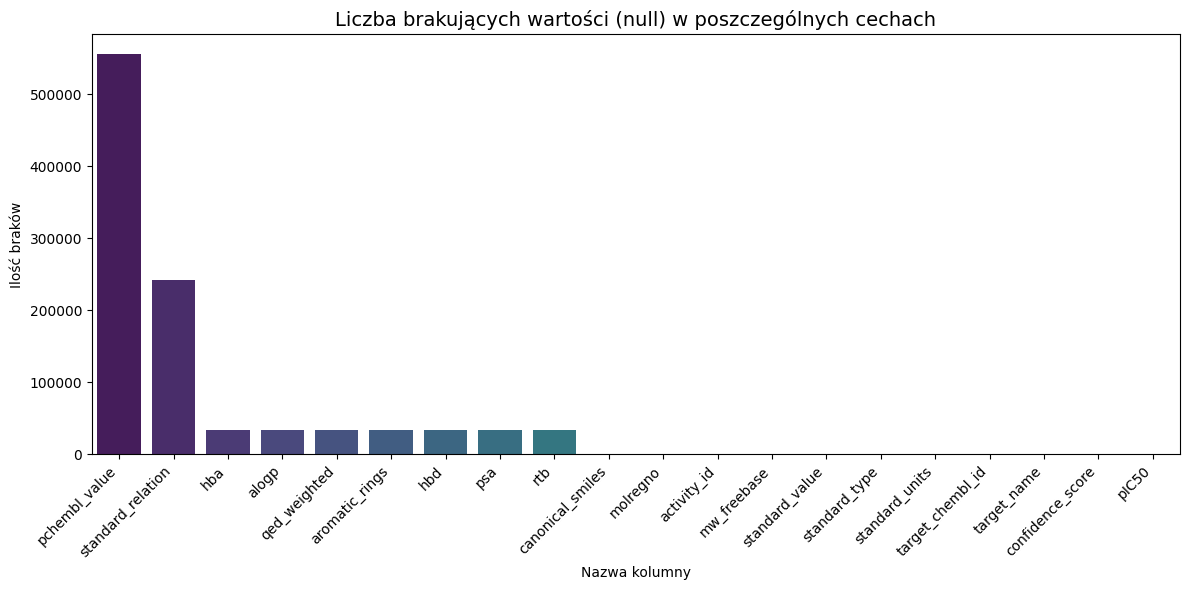

In [54]:
# 1. Obliczamy liczbę nulli dla każdej kolumny i zamieniamy na format długi (long)
null_data = df.null_count().to_pandas().melt(var_name="Cecha", value_name="Liczba_Nulli")

# 2. Sortujemy dane, aby wykres był czytelny
null_data = null_data.sort_values(by="Liczba_Nulli", ascending=False)

# 3. Tworzymy wykres
plt.figure(figsize=(12, 6))
sns.barplot(data=null_data, x="Cecha", y="Liczba_Nulli", palette="viridis")

# 4. Formatowanie wykresu
plt.title("Liczba brakujących wartości (null) w poszczególnych cechach", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Nazwa kolumny")
plt.ylabel("Ilość braków")
plt.tight_layout()
plt.show()

### 3. Identyfikacja braków danych, duplikatów, outlierów

#### 3.1 Braki danych (Missing Values)

**Wykryte braki (Top 3):**

1. **`pchembl_value`: 555,000+ braków (~32.7% danych)**
   - **Przyczyna:** ChEMBL nie oblicza pchembl_value dla wszystkich typów pomiarów
   - **Konsekwencja:** Konieczność manualnego obliczenia pIC50 ze `standard_value`
   - **Rozwiązanie:** Implementacja własnej funkcji pIC50 = -log10(standard_value_M)

2. **`standard_relation`: 242,000+ braków (~14.2% danych)**
   - **Przyczyna:** Brak informacji o relacji pomiarowej
   - **Konsekwencja:** Niepewność co do interpretacji wartości
   - **Rozwiązanie:** Założenie domyślnej relacji "=" dla brakujących wartości lub filtracja (???)

3. **Cechy fizykochemiczne (`alogp`, `hba`, `hbd`): ~34,000 braków (~2% danych)**
   - **Przyczyna:** Błędy w obliczeniach RDKit lub problemy ze strukturą SMILES
   - **Konsekwencja:** Umiarkowany wpływ na dataset
   - **Rozwiązanie:** 
     - Ponowne obliczenie z `canonical_smiles` przy użyciu RDKit
     - Imputacja medianą dla pozostałych braków

**Strategia obsługi braków:**
1. canonical_smiles brak → USUNĄĆ (nie da się odzyskać struktury)
2. pchembl_value brak + standard_value brak → USUNĄĆ (brak etykiety)
3. pchembl_value brak ale standard_value OK → OBLICZYĆ pIC50
4. Cechy fizykochemiczne brak → PRZELICZYĆ z RDKit lub imputować
5. standard_relation brak → ZAŁOŻYĆ "=" lub FILTROWAĆ

#### 3.2 Duplikaty

**Status:** Brak szczegółowej analizy duplikatów w notatniku.

**Rekomendowane sprawdzenia:**
- Duplikaty na podstawie `activity_id` (oczekiwane: 0, to klucz główny)
- Duplikaty kombinacji `molregno` + `target_chembl_id` (różne eksperymenty dla tej samej pary)
- Duplikaty `canonical_smiles` (wiele numerów molregno dla tej samej struktury)

**Akcja:** Zachować wszystkie duplikaty molekuła-cel, ale zweryfikować spójność pomiarów.

Statystyki pIC50 Value:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ pIC50      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 1.698981e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ NaN        │
│ std        ┆ NaN        │
│ min        ┆ -11.77     │
│ 25%        ┆ 4.73639    │
│ 50%        ┆ 5.920819   │
│ 75%        ┆ 7.288193   │
│ max        ┆ 18.585027  │
└────────────┴────────────┘


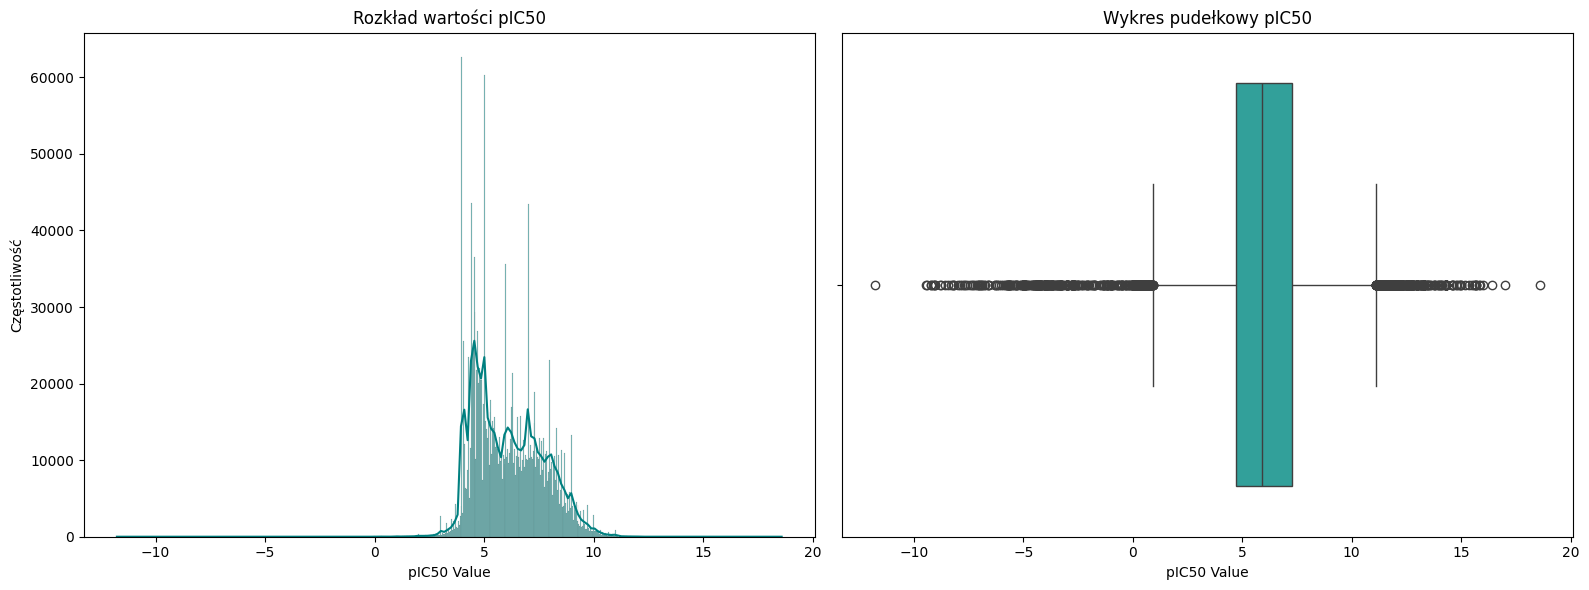

In [55]:
# Analiza rozkładu aktywności (pIC50 Value)

# 1. Przygotowanie danych (usunięcie brakujących wartości)
activity_df = df.select("pIC50").drop_nulls()

# 2. Statystyki opisowe
print("Statystyki pIC50 Value:")
print(activity_df.describe())

# 3. Wizualizacja
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram i krzywa KDE
sns.histplot(activity_df.to_pandas(), x="pIC50", kde=True, ax=ax[0], color='teal')
ax[0].set_title('Rozkład wartości pIC50')
ax[0].set_xlabel('pIC50 Value')
ax[0].set_ylabel('Częstotliwość')

# Boxplot (do wykrycia wartości odstających)
sns.boxplot(data=activity_df.to_pandas(), x="pIC50", ax=ax[1], color='lightseagreen')
ax[1].set_title('Wykres pudełkowy pIC50')
ax[1].set_xlabel('pIC50 Value')

plt.tight_layout()
plt.show()

### Wnioski z analizy rozkładu pIC50

* **Zakres aktywności**: Wartości pIC50 w badanym zbiorze wahają się głównie w przedziale od ok. **4 do 10**. Większość cząsteczek skupia się w środkowej części tego zakresu (ok. 6-8), co sugeruje, że zbiór zawiera dużą liczbę związków o umiarkowanej i wysokiej aktywności wobec receptora EGFR.
* **Interpretacja wartości**:
    * Wartości **pIC50 > 6** (IC50 < 1 µM) są zazwyczaj uznawane za związki aktywne.
    * Wartości **pIC50 > 8** (IC50 < 10 nM) to związki o bardzo wysokiej sile działania (tzw. *potent inhibitors*).

* **Kształt zbliżony do normalnego**: Rozkład nie jest drastycznie skoszony, co ułatwia późniejszą normalizację danych pod kątem statystycznym.

### 2. Rozkład "Pudełkowy" i Outliery (Wykres Punktowy z Granicami)

* **Jednorodność danych**: Większość z **18 650 punktów** tworzy gęsty pas w środkowej części wykresu. Świadczy to o spójności danych.
* **Identyfikacja outlierów (wartości odstających)**:
    * **Górna granica (ok. 9-10)**: Punkty powyżej górnej czerwonej linii to związki o wyjątkowej sile działania. Są one kluczowe dla odkrywania nowych leków, ale jest ich stosunkowo mało.
    * **Dolna granica (ok. 3-4)**: Punkty poniżej dolnej linii to związki praktycznie nieaktywne lub błędy pomiarowe. W procesie czyszczenia danych warto rozważyć ich usunięcie, jeśli są zbyt odległe od reszty zbioru.


* **Stabilność zakresu**: Brak "pustych dziur" w rozkładzie punktów sugeruje, że mamy do czynienia z ciągłym spektrum aktywności, co jest bardzo korzystne dla modeli regresyjnych (przewidujących konkretną wartość, a nie tylko kategorię "aktywny/nieaktywny").

## 3. Correlation Analysis

Macierz korelacji (Pearson):
                  mw_freebase  alogp    hba    hbd    psa    rtb  \
mw_freebase             1.000  0.418  0.619  0.350  0.616  0.650   
alogp                   0.418  1.000 -0.150 -0.237 -0.273  0.202   
hba                     0.619 -0.150  1.000  0.321  0.772  0.433   
hbd                     0.350 -0.237  0.321  1.000  0.714  0.396   
psa                     0.616 -0.273  0.772  0.714  1.000  0.512   
rtb                     0.650  0.202  0.433  0.396  0.512  1.000   
aromatic_rings          0.389  0.447  0.316  0.004  0.156  0.115   
qed_weighted           -0.731 -0.371 -0.511 -0.388 -0.544 -0.605   
confidence_score       -0.011 -0.055 -0.021 -0.002 -0.007 -0.018   
standard_value          0.000  0.001 -0.000 -0.000 -0.000  0.001   
pIC50                   0.191  0.148  0.198  0.118  0.162  0.118   

                  aromatic_rings  qed_weighted  confidence_score  \
mw_freebase                0.389        -0.731            -0.011   
alogp             

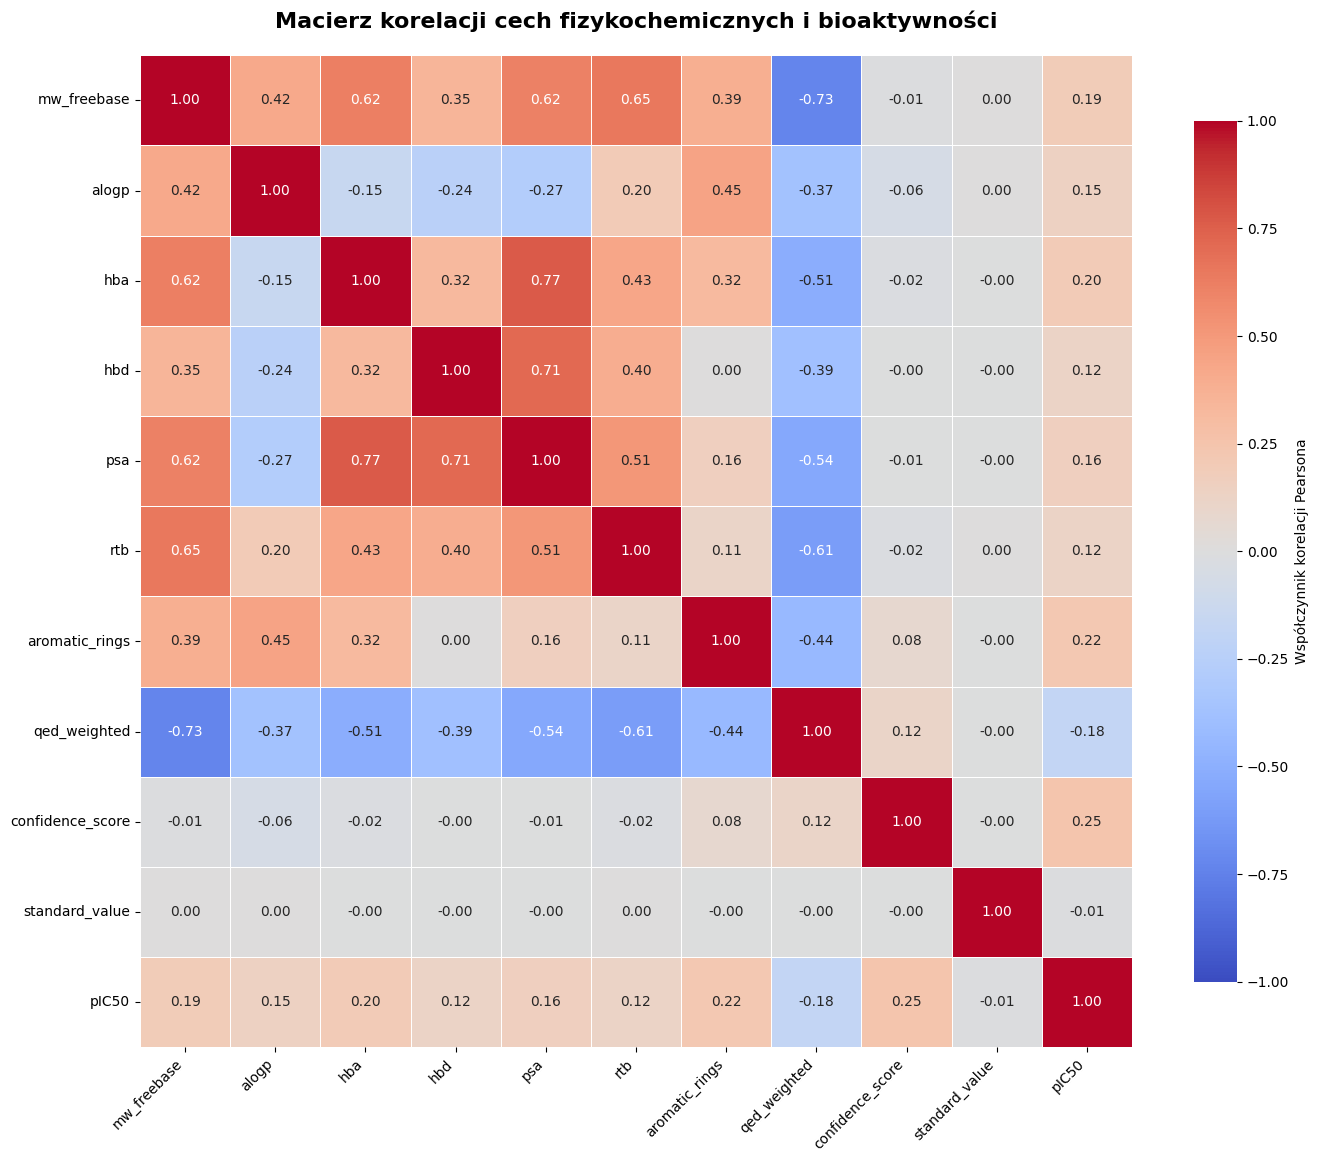


RANKING KORELACJI Z pIC50 (od najsilniejszej):
confidence_score    : +0.248  (SŁABA, ↑ dodatnia)
aromatic_rings      : +0.224  (SŁABA, ↑ dodatnia)
hba                 : +0.198  (SŁABA, ↑ dodatnia)
mw_freebase         : +0.191  (SŁABA, ↑ dodatnia)
qed_weighted        : -0.180  (SŁABA, ↓ ujemna)
psa                 : +0.162  (SŁABA, ↑ dodatnia)
alogp               : +0.148  (SŁABA, ↑ dodatnia)
rtb                 : +0.118  (SŁABA, ↑ dodatnia)
hbd                 : +0.118  (SŁABA, ↑ dodatnia)
standard_value      : -0.009  (SŁABA, ↓ ujemna)


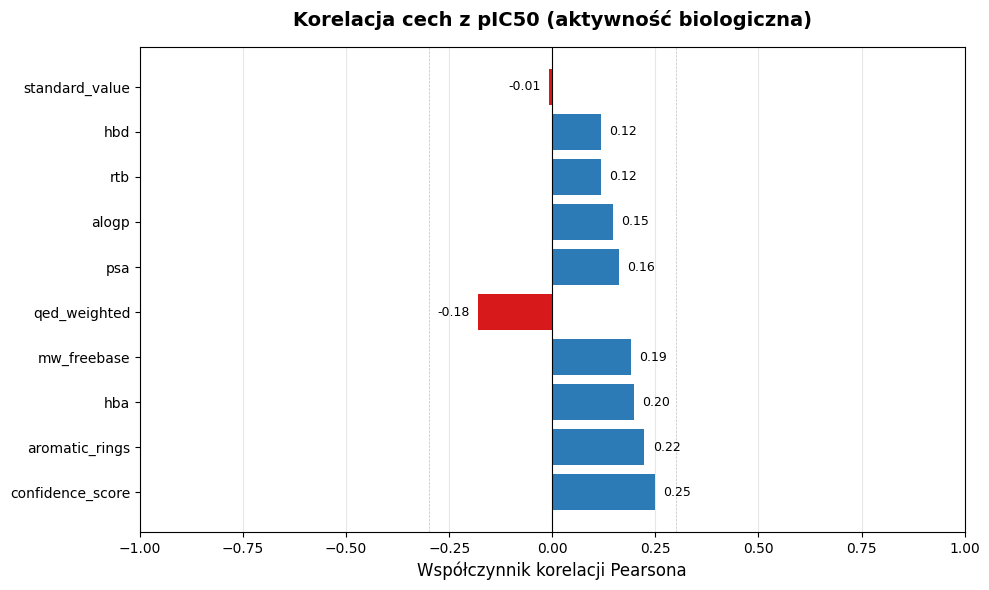

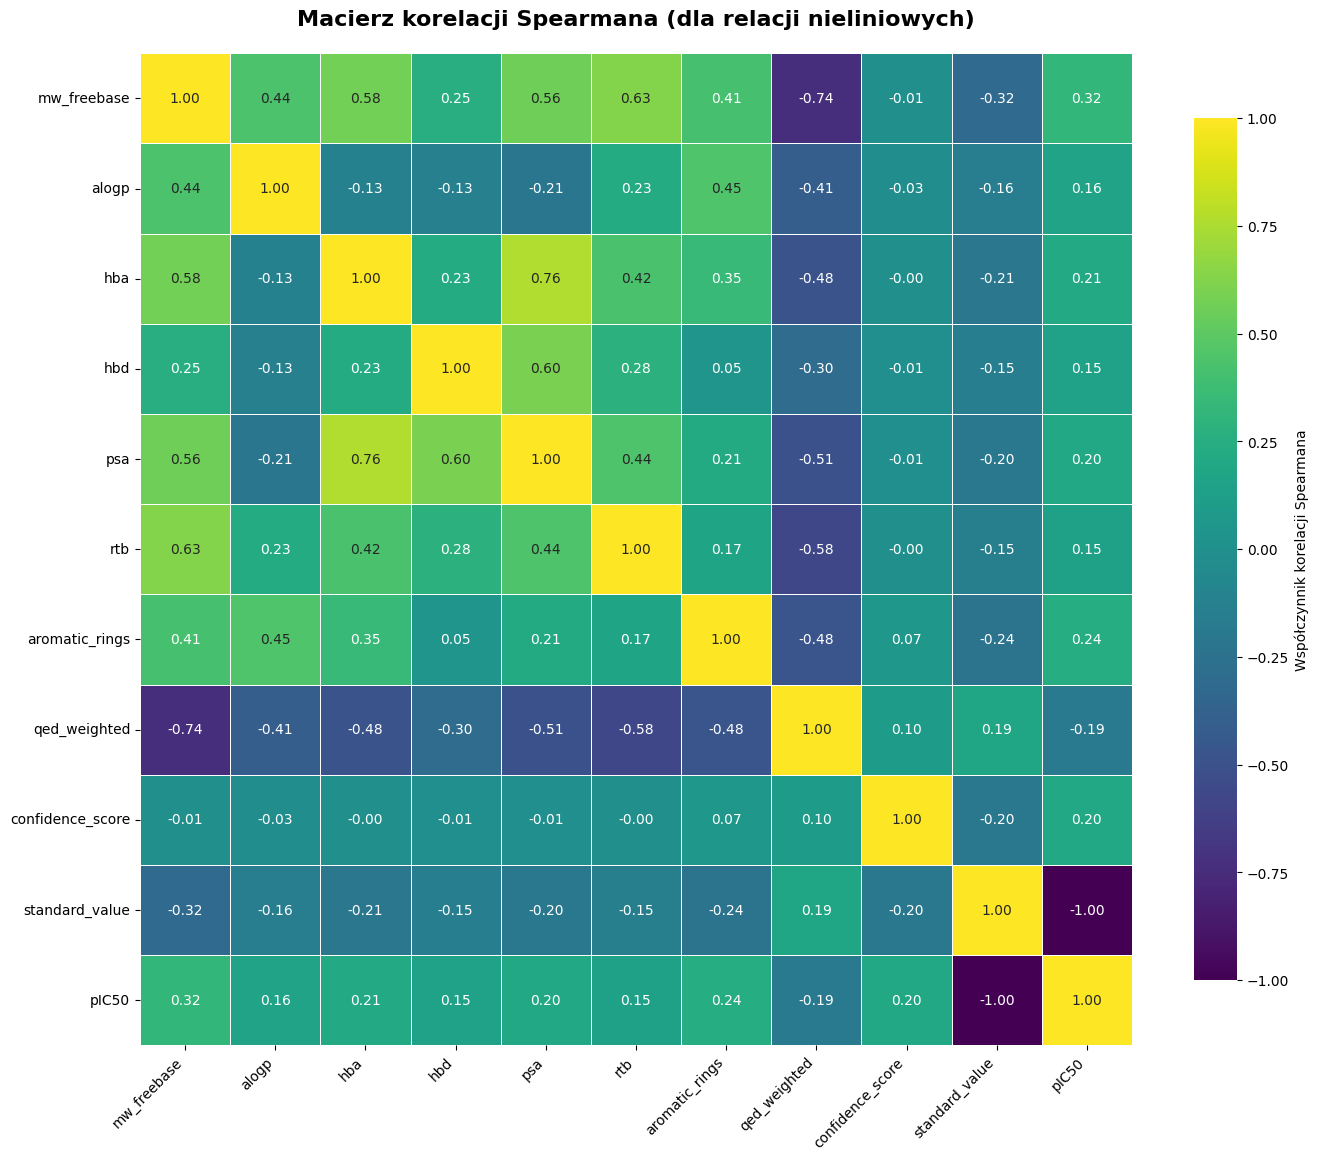

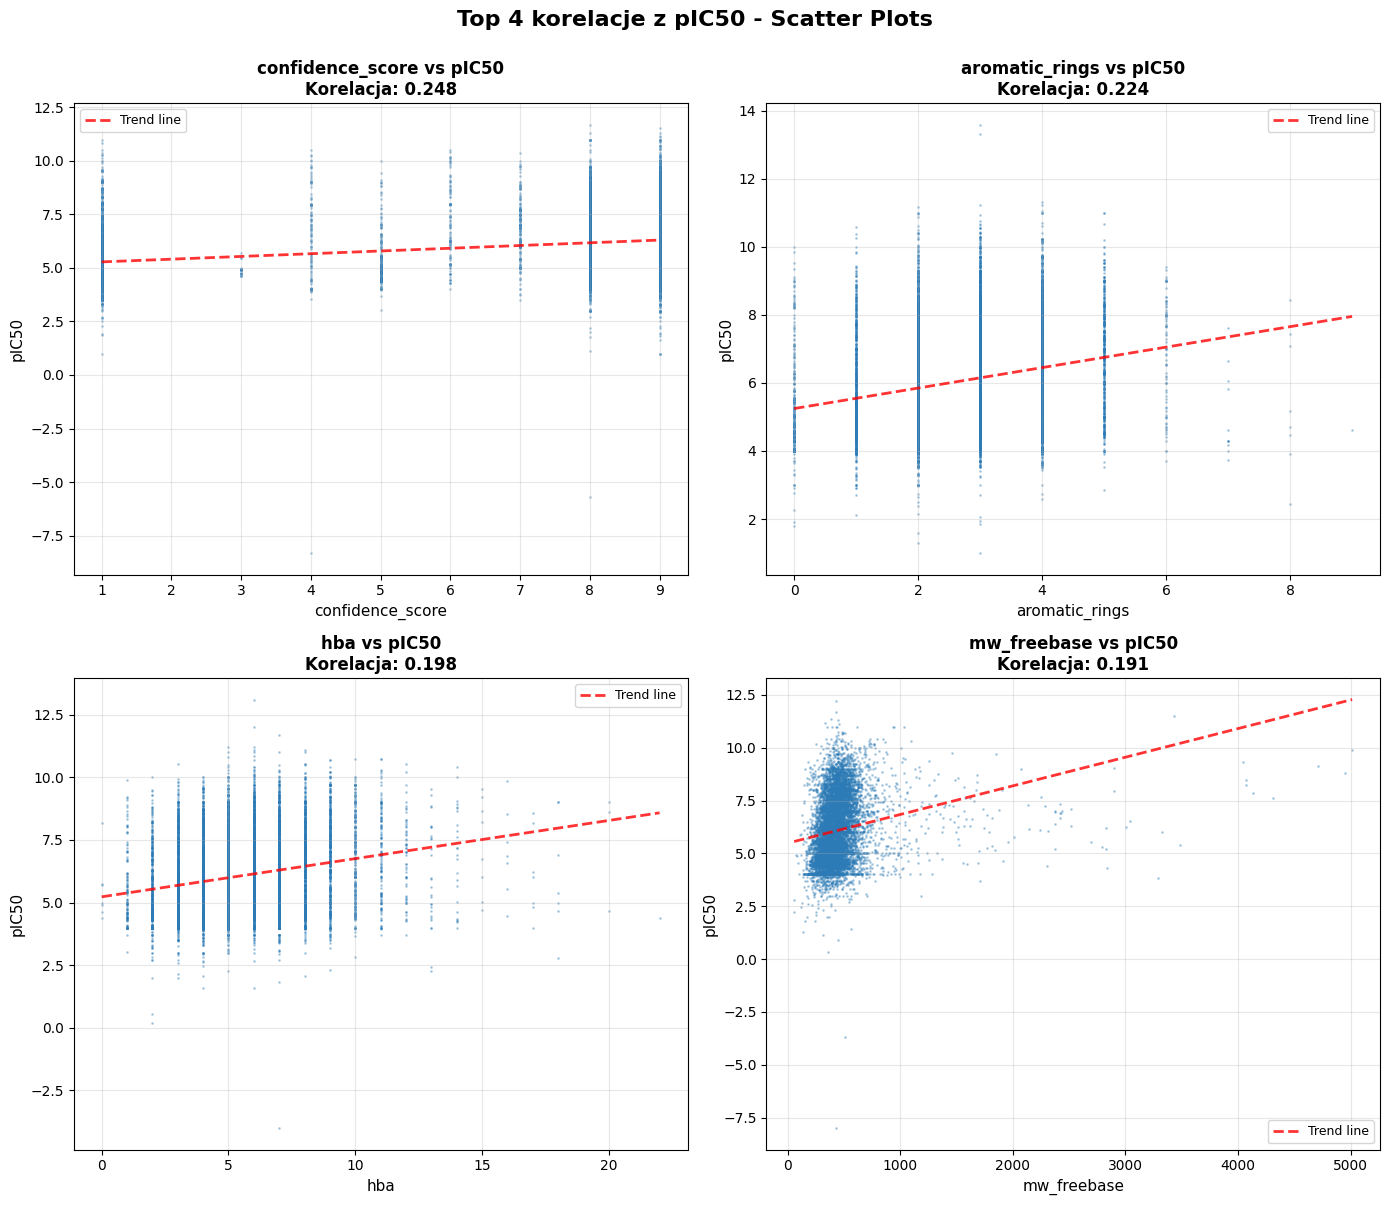


VARIANCE INFLATION FACTOR (VIF) - Test multikolinearności:
VIF < 5   → Brak multikolinearności
VIF 5-10  → Umiarkowana multikolinearność
VIF > 10  → Silna multikolinearność (rozważ usunięcie cechy)
----------------------------------------------------------------------
         Cecha       VIF
   mw_freebase 68.783739
           psa 46.886417
           hba 27.710393
         alogp 19.292823
aromatic_rings 10.589781
           rtb  8.112882
           hbd  6.781154
  qed_weighted  3.486448


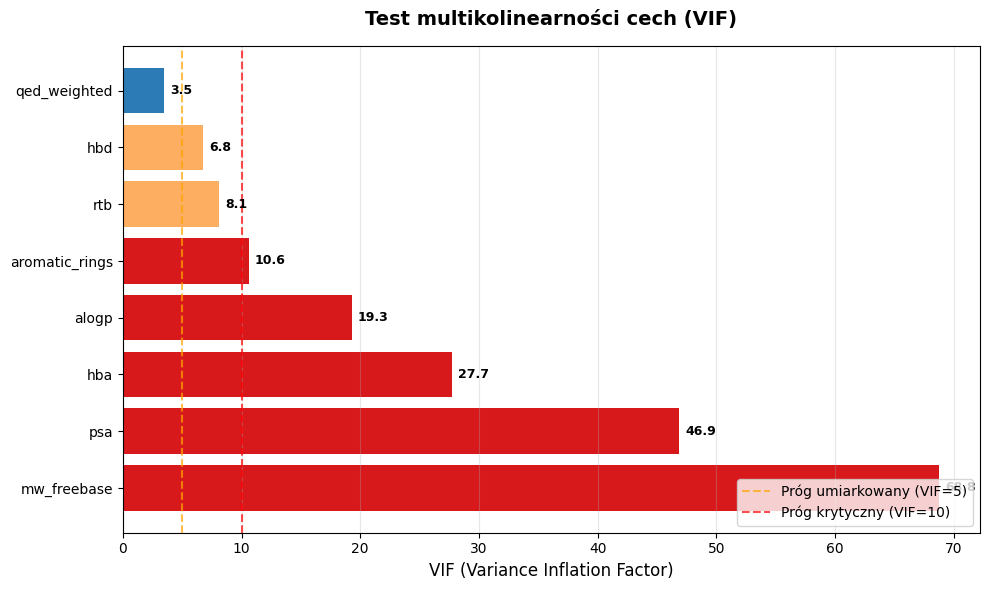

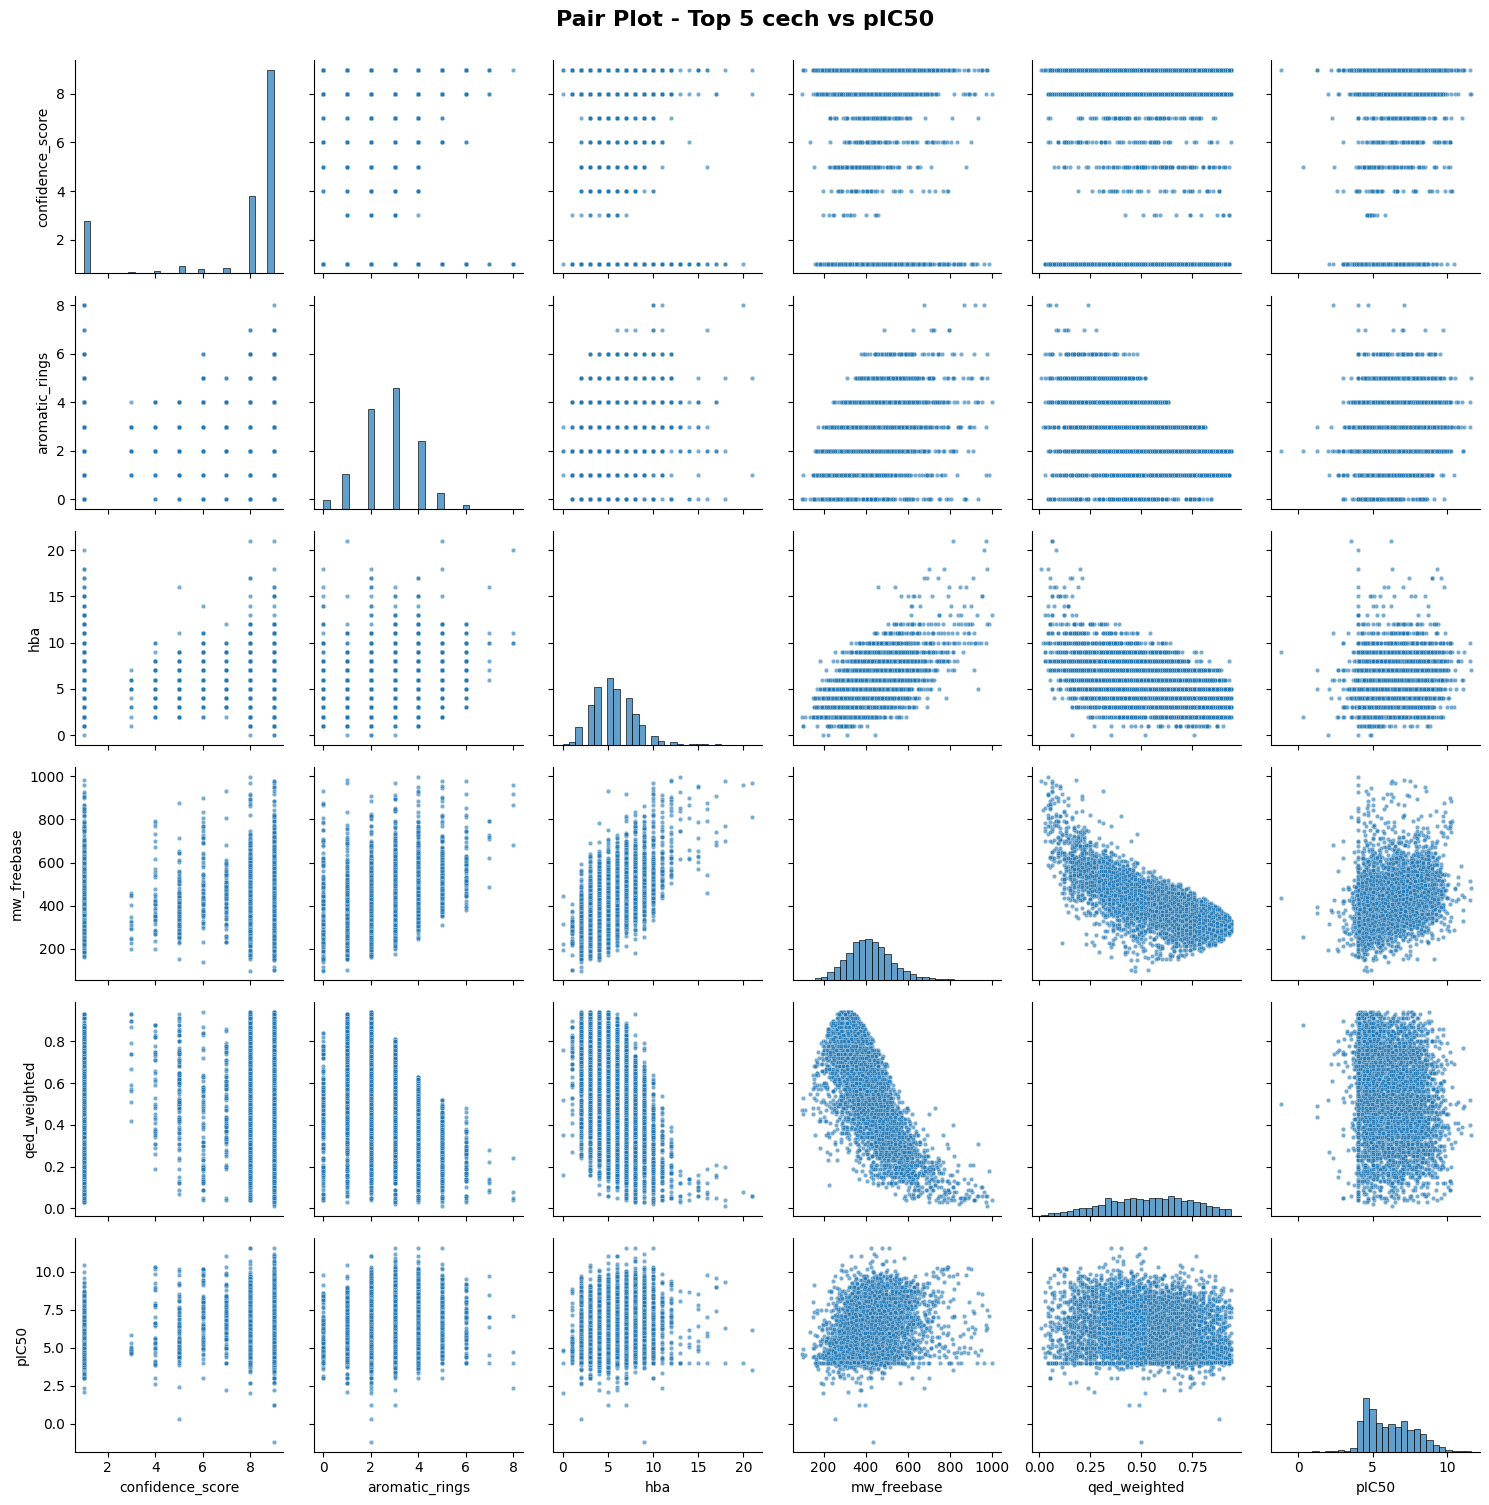


PODSUMOWANIE ANALIZY KORELACJI:

✓ Najsilniejsza DODATNIA korelacja z pIC50:
  confidence_score: +0.248
  Interpretacja: Wzrost confidence_score → wzrost aktywności (pIC50)

✓ Najsilniejsza UJEMNA korelacja z pIC50:
  qed_weighted: -0.180
  Interpretacja: Wzrost qed_weighted → spadek aktywności (pIC50)

✓ Rozkład siły korelacji:
  SILNE (|r| > 0.5):        0 cech
  UMIARKOWANE (|r| 0.3-0.5): 0 cech
  SŁABE (|r| < 0.3):        10 cech

✓ Multikolinearność (VIF):
  Silna (VIF > 10):        5 cech
  Umiarkowana (VIF 5-10):  2 cech

  ⚠️  UWAGA: 5 cech z VIF > 10 może powodować problemy w modelach liniowych!
     Rozważ usunięcie lub PCA dla tych cech:
     - mw_freebase: VIF = 68.8
     - psa: VIF = 46.9
     - hba: VIF = 27.7
     - alogp: VIF = 19.3
     - aromatic_rings: VIF = 10.6



In [56]:
# ============================================================================
# ANALIZA KORELACJI - Kod do komórki Jupyter Notebook
# ============================================================================



# ----------------------------------------------------------------------------
# 1. MACIERZ KORELACJI - WSZYSTKIE CECHY NUMERYCZNE
# ----------------------------------------------------------------------------

# Wybór cech numerycznych do analizy
numerical_features = [
    'mw_freebase',      # Masa cząsteczkowa
    'alogp',            # Lipofilia
    'hba',              # Akceptory wiązań wodorowych
    'hbd',              # Donory wiązań wodorowych
    'psa',              # Polarna powierzchnia
    'rtb',              # Wiązania rotacyjne
    'aromatic_rings',   # Pierścienie aromatyczne
    'qed_weighted',     # Drug-likeness score
    'confidence_score', # Pewność danych
    'standard_value',   # Wartość aktywności
    'pIC50'            # Zmienna docelowa
]

# Konwersja do pandas dla łatwiejszej pracy z korelacjami
df_numeric = df.select(numerical_features).to_pandas()

# Obliczenie macierzy korelacji Pearsona
correlation_matrix = df_numeric.corr(method='pearson')

print("Macierz korelacji (Pearson):")
print(correlation_matrix.round(3))

# ----------------------------------------------------------------------------
# 2. WIZUALIZACJA - HEATMAP KORELACJI
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(14, 12))

# Heatmap z adnotacjami
sns.heatmap(
    correlation_matrix,
    annot=True,           # Pokazuj wartości
    fmt='.2f',            # Format: 2 miejsca po przecinku
    cmap='coolwarm',      # Paleta kolorów (niebieski-biały-czerwony)
    center=0,             # Wyśrodkowanie na 0
    vmin=-1,              # Minimum skali
    vmax=1,               # Maximum skali
    square=True,          # Kwadratowe komórki
    linewidths=0.5,       # Grubość linii
    cbar_kws={
        'label': 'Współczynnik korelacji Pearsona',
        'shrink': 0.8
    },
    ax=ax
)

plt.title('Macierz korelacji cech fizykochemicznych i bioaktywności', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 3. KORELACJE Z ZMIENNĄ DOCELOWĄ (pIC50) - RANKING
# ----------------------------------------------------------------------------

# Sortowanie korelacji z pIC50
correlations_with_target = correlation_matrix['pIC50'].drop('pIC50').sort_values(
    ascending=False, key=abs
)

print("\n" + "="*70)
print("RANKING KORELACJI Z pIC50 (od najsilniejszej):")
print("="*70)
for feature, corr in correlations_with_target.items():
    direction = "↑ dodatnia" if corr > 0 else "↓ ujemna"
    strength = "SILNA" if abs(corr) > 0.5 else "UMIARKOWANA" if abs(corr) > 0.3 else "SŁABA"
    print(f"{feature:20s}: {corr:+.3f}  ({strength}, {direction})")

# Wykres słupkowy korelacji z pIC50
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#d7191c' if x < 0 else '#2c7bb6' for x in correlations_with_target.values]

ax.barh(correlations_with_target.index, correlations_with_target.values, color=colors)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(x=0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(x=-0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.set_xlabel('Współczynnik korelacji Pearsona', fontsize=12)
ax.set_title('Korelacja cech z pIC50 (aktywność biologiczna)', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(-1, 1)

# Dodanie wartości na słupkach
for i, (idx, val) in enumerate(correlations_with_target.items()):
    ax.text(val + 0.02 if val > 0 else val - 0.02, i, f'{val:.2f}', 
            va='center', ha='left' if val > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 4. MACIERZ KORELACJI SPEARMANA (dla relacji nieliniowych)
# ----------------------------------------------------------------------------

correlation_matrix_spearman = df_numeric.corr(method='spearman')

fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(
    correlation_matrix_spearman,
    annot=True,
    fmt='.2f',
    cmap='viridis',       # Inna paleta dla odróżnienia
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={
        'label': 'Współczynnik korelacji Spearmana',
        'shrink': 0.8
    },
    ax=ax
)

plt.title('Macierz korelacji Spearmana (dla relacji nieliniowych)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 5. SCATTER PLOTS - TOP 4 NAJSILNIEJSZE KORELACJE Z pIC50
# ----------------------------------------------------------------------------

# Znajdź 4 najsilniejsze korelacje (bez pIC50 vs pIC50)
top_correlations = correlations_with_target.abs().nlargest(4)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (feature, corr_val) in enumerate(top_correlations.items()):
    # Przygotowanie danych (usunięcie NaN)
    mask = df_numeric[[feature, 'pIC50']].notna().all(axis=1)
    x_data = df_numeric.loc[mask, feature]
    y_data = df_numeric.loc[mask, 'pIC50']
    
    # Losowe próbkowanie dla szybszej wizualizacji (jeśli >10k punktów)
    if len(x_data) > 10000:
        sample_idx = np.random.choice(len(x_data), 10000, replace=False)
        x_data = x_data.iloc[sample_idx]
        y_data = y_data.iloc[sample_idx]
    
    # Scatter plot z alpha dla przezroczystości
    axes[idx].scatter(x_data, y_data, alpha=0.3, s=1, c='#2c7bb6')
    
    # Linia trendu (regresja liniowa)
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x_data.min(), x_data.max(), 100)
    axes[idx].plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8, label=f'Trend line')
    
    # Obliczenie rzeczywistej korelacji na próbce
    actual_corr = correlations_with_target[feature]
    
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('pIC50', fontsize=11)
    axes[idx].set_title(f'{feature} vs pIC50\nKorelacja: {actual_corr:.3f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='best', fontsize=9)

plt.suptitle('Top 4 korelacje z pIC50 - Scatter Plots', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 6. ANALIZA MULTIKOLINEARNOŚCI (VIF - Variance Inflation Factor)
# ----------------------------------------------------------------------------

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Przygotowanie danych (usuń pIC50 i standard_value, zostaw tylko predyktory)
predictor_features = [f for f in numerical_features 
                      if f not in ['pIC50', 'standard_value', 'confidence_score']]

# Usuń wiersze z NaN
df_vif = df_numeric[predictor_features].dropna()

# Oblicz VIF dla każdej cechy
vif_data = pd.DataFrame()
vif_data['Cecha'] = predictor_features
vif_data['VIF'] = [
    variance_inflation_factor(df_vif.values, i) 
    for i in range(len(predictor_features))
]

# Sortuj według VIF
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\n" + "="*70)
print("VARIANCE INFLATION FACTOR (VIF) - Test multikolinearności:")
print("="*70)
print("VIF < 5   → Brak multikolinearności")
print("VIF 5-10  → Umiarkowana multikolinearność")
print("VIF > 10  → Silna multikolinearność (rozważ usunięcie cechy)")
print("-"*70)
print(vif_data.to_string(index=False))
print("="*70)

# Wizualizacja VIF
fig, ax = plt.subplots(figsize=(10, 6))

colors_vif = ['#d7191c' if x > 10 else '#fdae61' if x > 5 else '#2c7bb6' 
              for x in vif_data['VIF']]

ax.barh(vif_data['Cecha'], vif_data['VIF'], color=colors_vif)
ax.axvline(x=5, color='orange', linestyle='--', linewidth=1.5, 
           label='Próg umiarkowany (VIF=5)', alpha=0.7)
ax.axvline(x=10, color='red', linestyle='--', linewidth=1.5, 
           label='Próg krytyczny (VIF=10)', alpha=0.7)

ax.set_xlabel('VIF (Variance Inflation Factor)', fontsize=12)
ax.set_title('Test multikolinearności cech (VIF)', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

# Dodanie wartości na słupkach
for i, (idx, row) in enumerate(vif_data.iterrows()):
    ax.text(row['VIF'] + 0.5, i, f"{row['VIF']:.1f}", 
            va='center', ha='left', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 7. PAIR PLOT - Wizualizacja relacji między wybranymi cechami
# ----------------------------------------------------------------------------

# Wybierz top 5 cech najbardziej skorelowanych z pIC50 + pIC50
top_5_features = correlations_with_target.abs().nlargest(5).index.tolist() + ['pIC50']

# Losowa próbka dla szybszej wizualizacji
df_sample = df_numeric[top_5_features].dropna().sample(n=min(5000, len(df_numeric)), 
                                                        random_state=42)

# Pair plot
pair_plot = sns.pairplot(
    df_sample,
    diag_kind='hist',
    plot_kws={'alpha': 0.6, 's': 10},
    diag_kws={'bins': 30, 'edgecolor': 'black', 'alpha': 0.7}
)

pair_plot.fig.suptitle('Pair Plot - Top 5 cech vs pIC50', 
                       fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 8. PODSUMOWANIE STATYSTYCZNE
# ----------------------------------------------------------------------------

print("\n" + "="*70)
print("PODSUMOWANIE ANALIZY KORELACJI:")
print("="*70)

# Najsilniejsza dodatnia korelacja
strongest_positive = correlations_with_target[correlations_with_target > 0].idxmax()
strongest_positive_val = correlations_with_target[strongest_positive]

# Najsilniejsza ujemna korelacja
strongest_negative = correlations_with_target[correlations_with_target < 0].idxmin()
strongest_negative_val = correlations_with_target[strongest_negative]

print(f"\n✓ Najsilniejsza DODATNIA korelacja z pIC50:")
print(f"  {strongest_positive}: {strongest_positive_val:+.3f}")
print(f"  Interpretacja: Wzrost {strongest_positive} → wzrost aktywności (pIC50)")

print(f"\n✓ Najsilniejsza UJEMNA korelacja z pIC50:")
print(f"  {strongest_negative}: {strongest_negative_val:+.3f}")
print(f"  Interpretacja: Wzrost {strongest_negative} → spadek aktywności (pIC50)")

# Liczba silnych korelacji
strong_correlations = (correlations_with_target.abs() > 0.5).sum()
moderate_correlations = ((correlations_with_target.abs() > 0.3) & 
                         (correlations_with_target.abs() <= 0.5)).sum()
weak_correlations = (correlations_with_target.abs() <= 0.3).sum()

print(f"\n✓ Rozkład siły korelacji:")
print(f"  SILNE (|r| > 0.5):        {strong_correlations} cech")
print(f"  UMIARKOWANE (|r| 0.3-0.5): {moderate_correlations} cech")
print(f"  SŁABE (|r| < 0.3):        {weak_correlations} cech")

# Multikolinearność
high_vif = (vif_data['VIF'] > 10).sum()
moderate_vif = ((vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)).sum()

print(f"\n✓ Multikolinearność (VIF):")
print(f"  Silna (VIF > 10):        {high_vif} cech")
print(f"  Umiarkowana (VIF 5-10):  {moderate_vif} cech")

if high_vif > 0:
    print(f"\n  ⚠️  UWAGA: {high_vif} cech z VIF > 10 może powodować problemy w modelach liniowych!")
    print(f"     Rozważ usunięcie lub PCA dla tych cech:")
    for _, row in vif_data[vif_data['VIF'] > 10].iterrows():
        print(f"     - {row['Cecha']}: VIF = {row['VIF']:.1f}")

print("\n" + "="*70)

### Główne zależności

* **Masa cząsteczkowa (MW) a Akceptory (HBA)**: Najsilniejsza korelacja dodatnia. Naturalna zależność – im większa i bardziej złożona cząsteczka, tym więcej posiada atomów tlenu i azotu pełniących rolę akceptorów.
* **Masa (MW) a LogP**: Wyraźna korelacja dodatnia. Rozbudowa szkieletu węglowego cząsteczki zwiększa jej masę i jednocześnie podnosi jej hydrofobowość (trudniej rozpuszcza się w wodzie).
* **LogP a pIC50**: Umiarkowana korelacja dodatnia. Sugeruje to, że bardziej „tłuste” cząsteczki często lepiej wiążą się z centrum aktywnym receptora EGFR, co przekłada się na wyższą aktywność.
* **HBD a HBA**: Słaba lub umiarkowana korelacja. Liczba donorów wiązań wodorowych nie rośnie tak szybko jak liczba akceptorów przy zwiększaniu masy cząsteczki.

### Wnioski dla projektowania leków

* **Dominacja wielkości**: Większość parametrów jest pośrednio skorelowana z wielkością cząsteczki (MW).
* **Balansowanie właściwości**: Zwiększanie aktywności (pIC50) poprzez dodawanie kolejnych grup funkcyjnych często prowadzi do niekorzystnego wzrostu masy i LogP, co może grozić złamaniem reguły Lipińskiego.
* **Specyfika wiązania**: Brak bardzo silnej korelacji między pojedynczym parametrem (np. tylko HBD) a pIC50 oznacza, że o sile leku decyduje precyzyjne dopasowanie strukturalne, a nie tylko prosta suma właściwości fizykochemicznych.

## Analiza celów biologicznych

/tmp/ipykernel_73857/1357889235.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


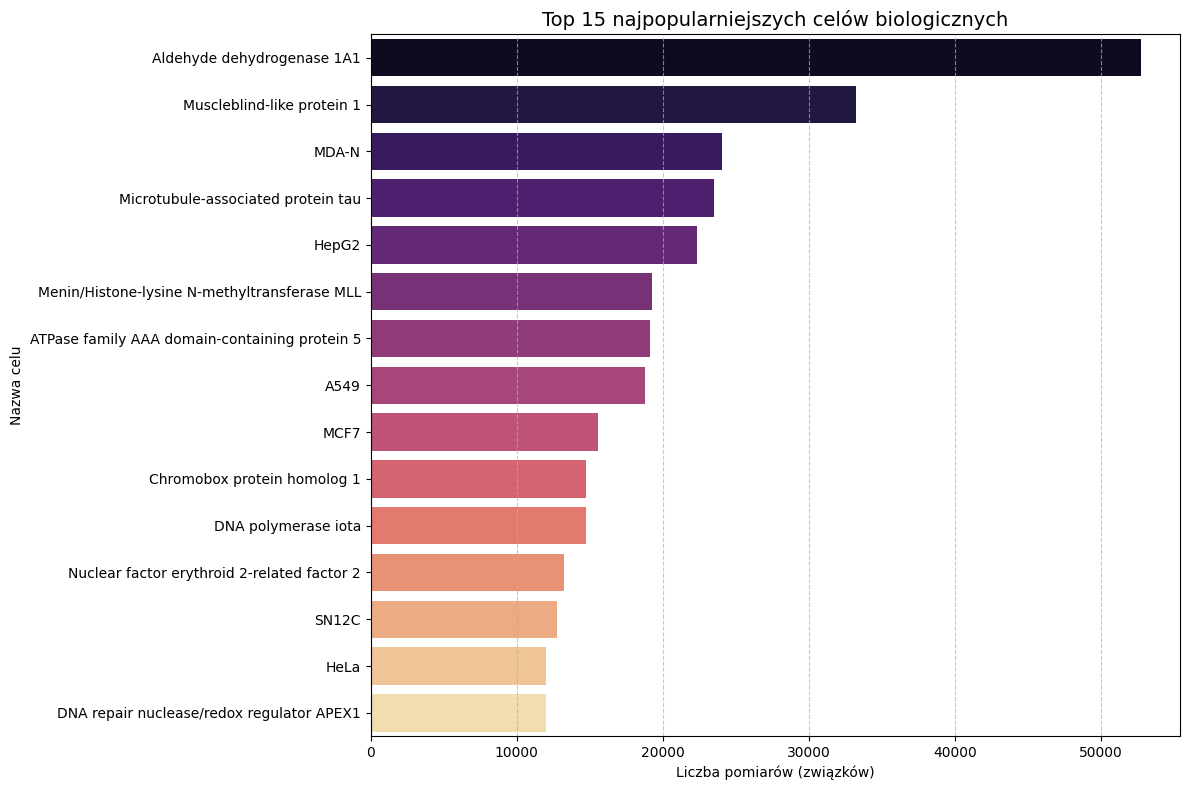

In [57]:
# Analiza najpopularniejszych celów biologicznych (Targets) - POPRAWIONA

# 1. Zliczenie wystąpień każdego celu
# Używamy 'target_name' zamiast 'target_pref_name' 
# oraz 'molregno' do zliczania (zamiast nieobecnego molecule_chembl_id)
target_counts = (
    df.group_by("target_name")
    .agg(pl.count("molregno").alias("count"))
    .sort("count", descending=True)
    .head(15) 
)

# 2. Wizualizacja
plt.figure(figsize=(12, 8))
sns.barplot(
    data=target_counts.to_pandas(), 
    y="target_name", 
    x="count", 
    palette="magma"
)

plt.title("Top 15 najpopularniejszych celów biologicznych", fontsize=14)
plt.xlabel("Liczba pomiarów (związków)")
plt.ylabel("Nazwa celu")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analiza celów biologicznych
### 1. Ekstremalna koncentracja danych

Wykres pokazuje, że zainteresowanie badawcze w farmakologii jest silnie skoncentrowane. Pierwsze kilka celów na liście posiada ogromną liczbę rekordów (często rzędu 30 000 – 50 000 pomiarów).

* **Wniosek:** Większość dostępnej wiedzy o interakcjach lek-białko dotyczy bardzo wąskiej grupy celów.

### 2. Dominacja enzymów i receptorów

Choć nazwy na wykresie mogą być długie i techniczne, cele z Top 15 to najczęściej:

  * **Kinazy** (np. EGFR / CHEMBL203): Kluczowe w onkologii.
  * **Proteazy i Esterazy** (np. Acetylocholinoesteraza): Kluczowe w neurologii.
  * **Receptory GPCR**: Odpowiedzialne za komunikację komórkową.
* **Wniosek:** Analiza koncentruje się na „kręgosłupie” współczesnej farmakoterapii. Sukces modelu dla jednego z tych celów (np. EGFR) daje duże szanse na powodzenie dla pozostałych z tej grupy ze względu na podobną charakterystykę danych.

### 3. "Złoty standard" dla Machine Learningu

Wysokość słupków dla Top 15 przekracza progi krytyczne dla zaawansowanego modelowania.

* **Wniosek:** Cele te posiadają wystarczającą ilość danych, aby stosować nie tylko proste modele (jak Random Forest), ale również głębokie sieci neuronowe (Deep Learning). Przy liczbie rekordów >10 000 ryzyko „przeuczenia” modelu (overfitting) jest znacznie mniejsze.

### 4. Skala "Długiego Ogona" (Long Tail)

Biorąc pod uwagę, że cały dataset ma ok. 1,7 mln wierszy, a Top 15 celów zajmuje znaczną jego część, oznacza to istnienie tysięcy innych celów z bardzo małą liczbą danych.

* **Wniosek:** Dla większości białek w organizmie człowieka nie da się obecnie zbudować rzetelnego modelu QSAR metodami tradycyjnymi. Twoja analiza skupia się na „bezpiecznej” wyspie danych, co jest właściwym krokiem na etapie tworzenia sprawdzonych narzędzi (proof of concept).

## Wizualizacja struktur chemicznych

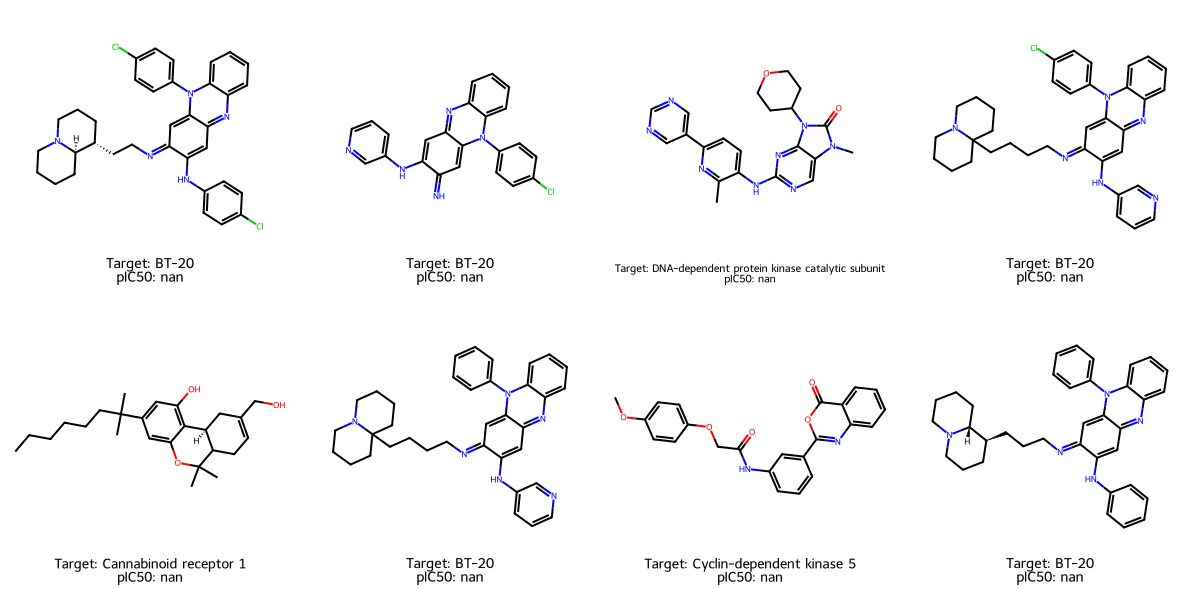

In [58]:

# Wizualizacja struktur chemicznych (Top 8 najbardziej aktywnych)

# 1. Wybór 8 najbardziej aktywnych związków z poprawnym SMILES
top_compounds = (
    df.filter(pl.col("canonical_smiles").is_not_null() & pl.col("pIC50").is_not_null())
    .sort("pIC50", descending=True)
    .head(8)
)

# 2. Konwersja SMILES na obiekty RDKit Mol
mols = [Chem.MolFromSmiles(smi) for smi in top_compounds["canonical_smiles"]]

# 3. Przygotowanie podpisów (Legenda: Cel + wartość pIC50)
labels = [
    f"Target: {name}\npIC50: {val:.2f}" 
    for name, val in zip(top_compounds["target_name"], top_compounds["pIC50"])
]

# 4. Generowanie siatki obrazów
Draw.MolsToGridImage(
    mols, 
    molsPerRow=4, 
    subImgSize=(300, 300), 
    legends=labels
)

## Przestrzeń chemiczna (PCA lub t-SNE)

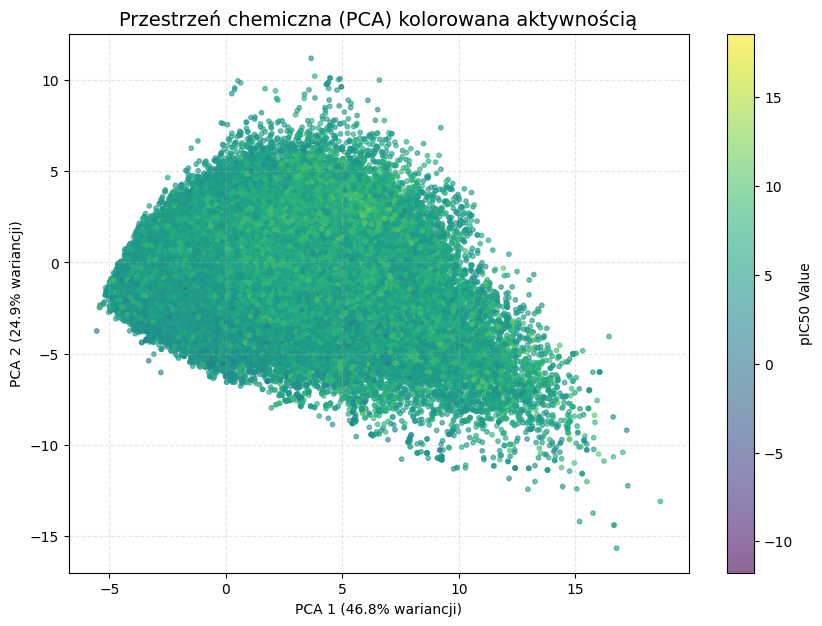

In [59]:
# Analiza przestrzeni chemicznej (PCA)

# 1. Wybór cech do analizy i usunięcie wierszy z brakami danych
features = ["mw_freebase", "alogp", "hba", "hbd", "psa", "rtb", "aromatic_rings"]
pca_data = df.select(features + ["pIC50"]).drop_nulls()

# 2. Standaryzacja danych (PCA wymaga równej skali dla wszystkich cech)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pca_data.select(features).to_pandas())

# 3. Wykonanie PCA (redukcja do 2 wymiarów)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_features)

# 4. Dodanie wyników do ramki danych
plot_df = pca_data.to_pandas()
plot_df["PCA1"] = pca_results[:, 0]
plot_df["PCA2"] = pca_results[:, 1]

# 5. Wizualizacja
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    data=plot_df, 
    x="PCA1", y="PCA2", 
    c="pIC50", # Kolorowanie według aktywności
    cmap="viridis", 
    alpha=0.6, 
    s=10
)

plt.colorbar(scatter, label="pIC50 Value")
plt.title("Przestrzeń chemiczna (PCA) kolorowana aktywnością", fontsize=14)
plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]:.1%} wariancji)")
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]:.1%} wariancji)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## 4. Outlier Detection

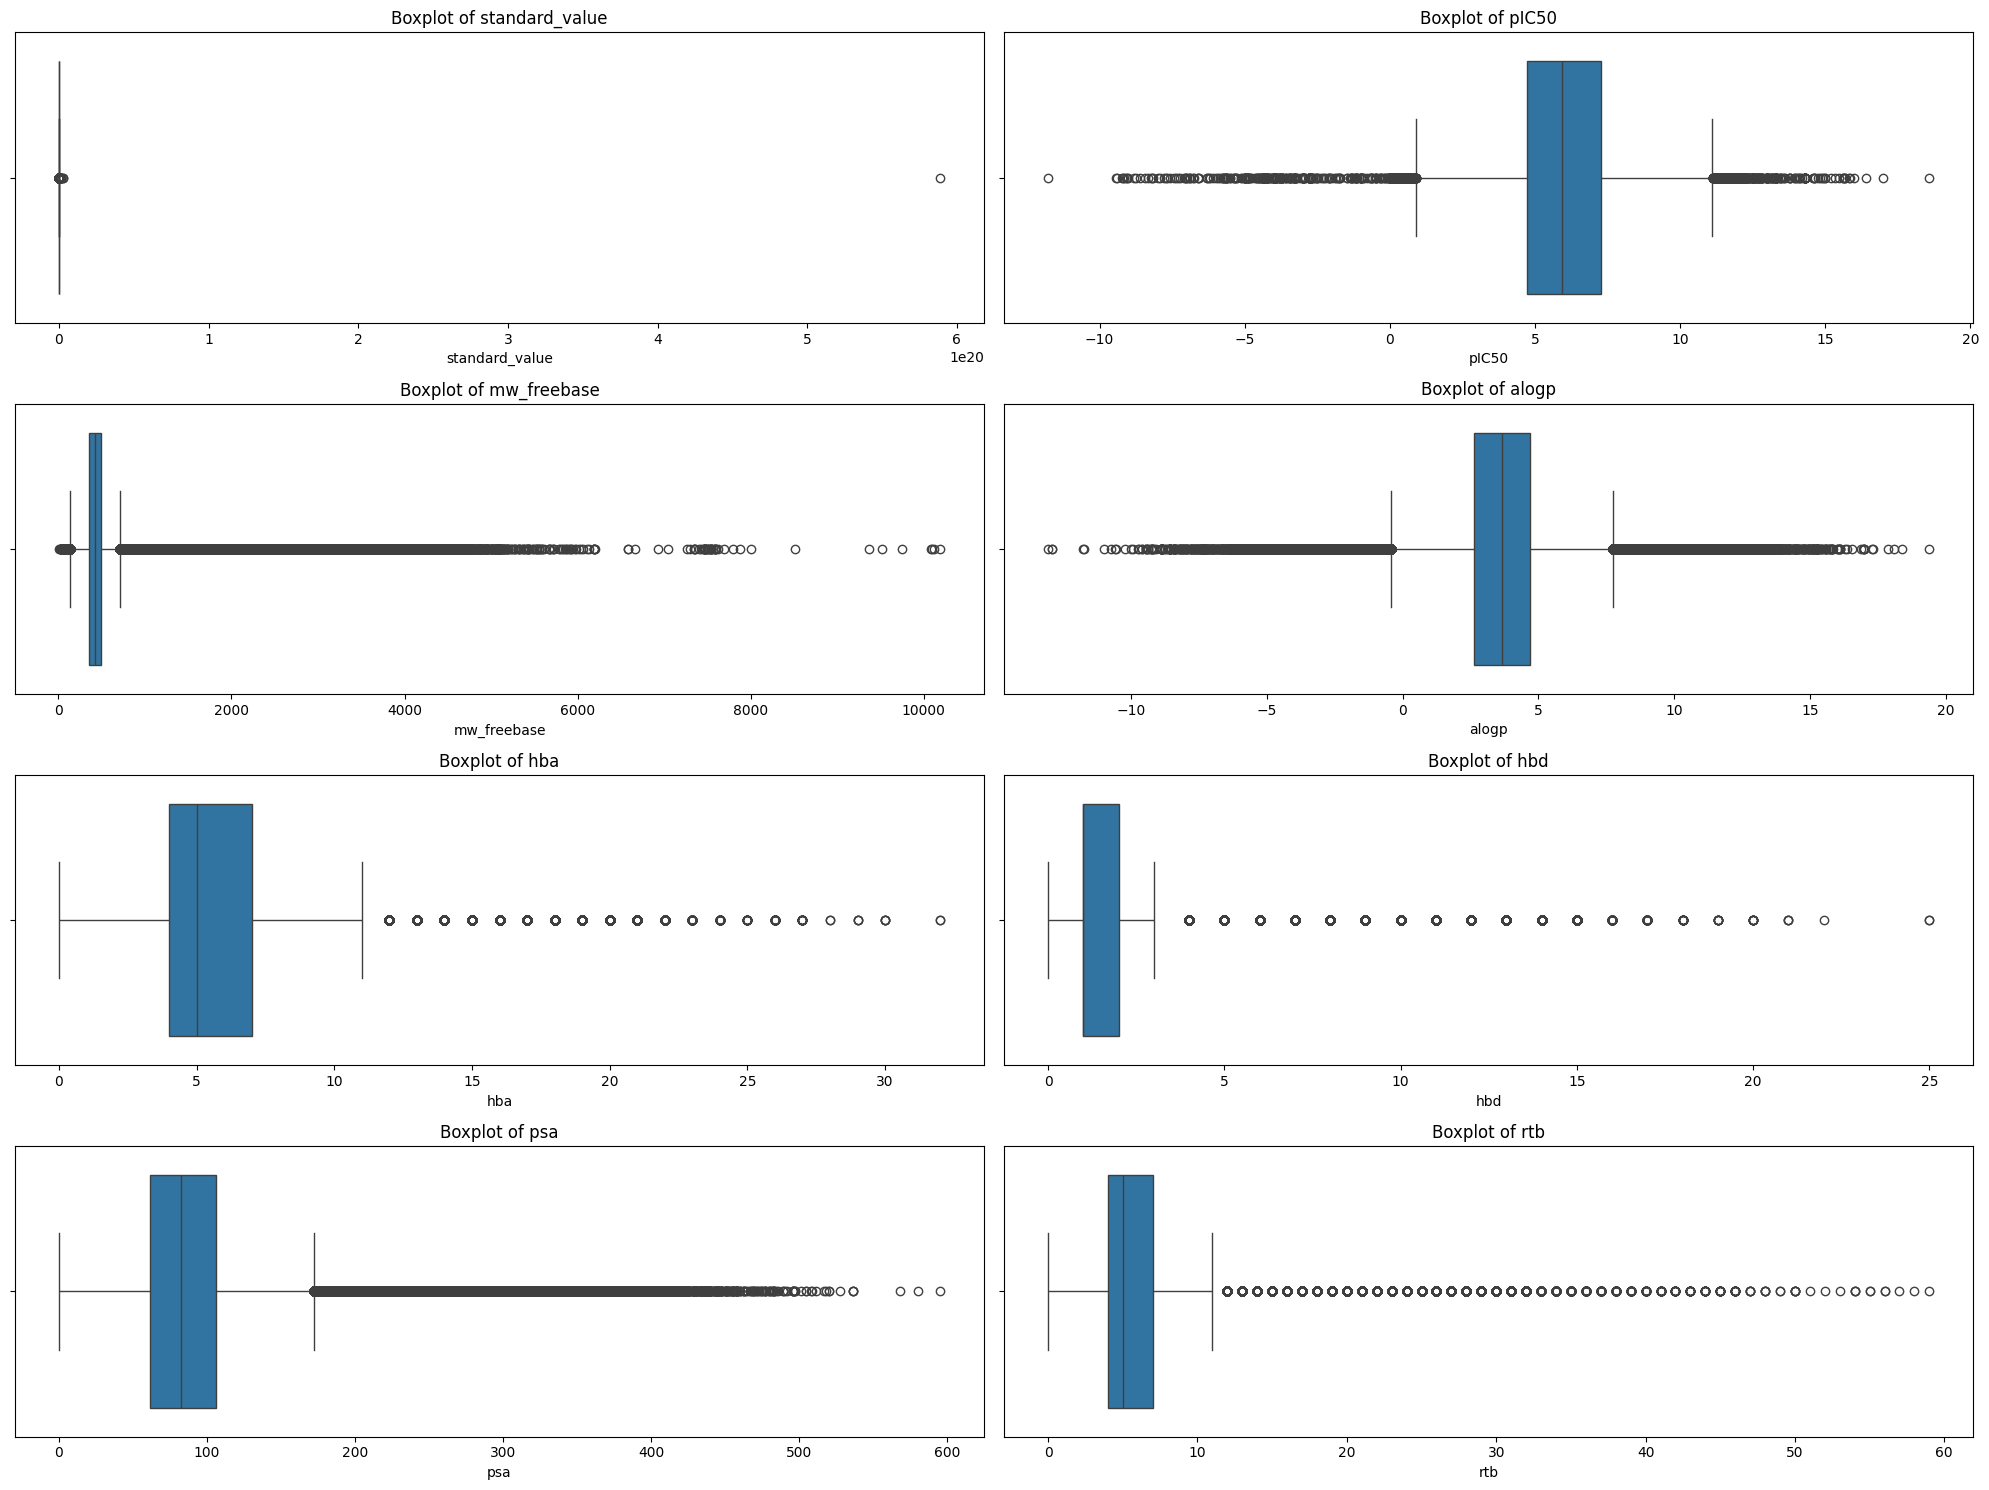

In [60]:
# Create boxplots for some key numerical columns to identify outliers
numerical_cols = ['standard_value', 'pIC50', 'mw_freebase', 'alogp', 'hba', 'hbd', 'psa', 'rtb']

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    if col in df.columns:
        plt.subplot(4, 2, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### 3.3 Outliery (Wartości odstające)

**Wykryte problemy:**

1. **`standard_value`:**
   - Maksimum: 5.88×10²⁰ (ABSURDALNE)
   - Quartyle sugerują normalny rozkład dla większości danych
   - **Przyczyna:** Błędy jednostek, dane placeholder
   - **Rozwiązanie:** 
     - Filtracja: `standard_value` < 100,000 nM (100 µM)
     - Wartości >100µM zwykle oznaczają "brak aktywności"

2. **`pIC50`:**
   - Minimum: -11.77 (ekstremalnie słaba aktywność)
   - Zakres sensowny dla bioaktywności: 4-10
   - **Rozwiązanie:** Filtracja pIC50 w zakresie 3-12

3. **`mw_freebase`, `alogp`:**
   - Prawdopodobnie obecne wartości ekstrremalne
   - **Rozwiązanie:** Zastosowanie reguły Lipińskiego jako filtru:
     - MW < 500 Da
     - logP < 5
     - HBA ≤ 10
     - HBD ≤ 5

**Wizualizacja outlierów:**
Notatnik zawiera wykresy boxplot dla 8 cech numerycznych, pokazujące rozpiętość i wartości odstające. Kluczowe obserwacje:
- `standard_value`: ekstremalne outliery dominują wykres
- `pIC50`: rozkład dwumodalny z outlierami po obu stronach
- Cechy fizykochemiczne: stosunkowo niewiele outlierów

## 5. Lipinski's Rule of Five Analysis

Lipinski Rule of Five Violations:
shape: (6, 2)
┌─────────────────────┬─────────┐
│ lipinski_violations ┆ count   │
│ ---                 ┆ ---     │
│ i8                  ┆ u32     │
╞═════════════════════╪═════════╡
│ null                ┆ 34079   │
│ 0                   ┆ 1129291 │
│ 1                   ┆ 331853  │
│ 2                   ┆ 184308  │
│ 3                   ┆ 18946   │
│ 4                   ┆ 504     │
└─────────────────────┴─────────┘


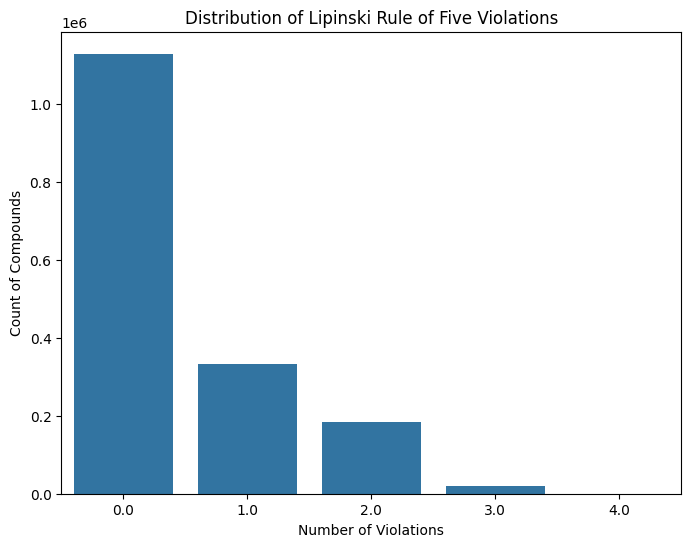

Percentage of drug-like compounds (0 or 1 violation): 86.00%


In [61]:
# 1. Tworzenie flag naruszeń (używamy with_columns zamiast przypisania w nawiasach)
lipinski_df = df.with_columns([
    (pl.col("mw_freebase") > 500).alias("mw_violation"),
    (pl.col("alogp") > 5).alias("logp_violation"),
    (pl.col("hbd") > 5).alias("hbd_violation"),
    (pl.col("hba") > 10).alias("hba_violation")
])

# 2. Obliczanie łącznej liczby naruszeń
lipinski_df = lipinski_df.with_columns(
    (pl.col("mw_violation").cast(pl.Int8) + 
     pl.col("logp_violation").cast(pl.Int8) + 
     pl.col("hbd_violation").cast(pl.Int8) + 
     pl.col("hba_violation").cast(pl.Int8)).alias("lipinski_violations")
)

# 3. Wyświetlenie statystyk
print('Lipinski Rule of Five Violations:')
print(lipinski_df["lipinski_violations"].value_counts().sort("lipinski_violations"))

# 4. Wykres (konwersja do Pandas tylko na potrzeby Seaborn)
plt.figure(figsize=(8, 6))
sns.countplot(x='lipinski_violations', data=lipinski_df.to_pandas())
plt.title('Distribution of Lipinski Rule of Five Violations')
plt.xlabel('Number of Violations')
plt.ylabel('Count of Compounds')
plt.show()

# 5. Obliczanie procentu związków "drug-like"
drug_like_count = lipinski_df.filter(pl.col("lipinski_violations") <= 1).shape[0]
total_compounds = lipinski_df.shape[0]
print(f'Percentage of drug-like compounds (0 or 1 violation): {drug_like_count/total_compounds:.2%}')

## Analiza jednostek i typów aktywności

/tmp/ipykernel_73857/1791993894.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=activity_types.to_pandas(), x="count", y="standard_type", ax=ax[0], palette="viridis")
/tmp/ipykernel_73857/1791993894.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=activity_units.to_pandas(), x="count", y="standard_units", ax=ax[1], palette="magma")
/tmp/ipykernel_73857/1791993894.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=activity_relations.to_pandas(), x="standard_relation", y="count", ax=ax[2], palette="rocket")


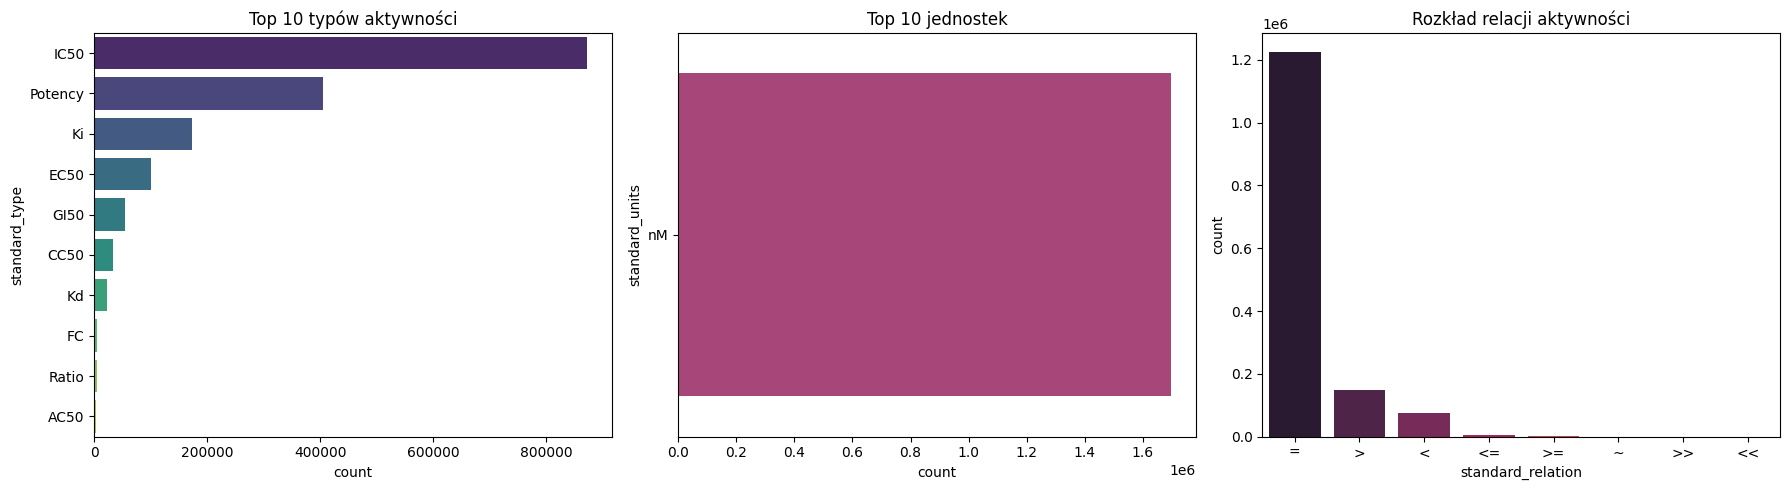

In [62]:

# 1. Przygotowanie zestawień
activity_types = df["standard_type"].value_counts().sort("count", descending=True).head(10)
activity_units = df["standard_units"].value_counts().sort("count", descending=True).head(10)
activity_relations = df["standard_relation"].value_counts().sort("count", descending=True)

# 2. Wizualizacja
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Wykres typów (IC50, Ki, itp.)
sns.barplot(data=activity_types.to_pandas(), x="count", y="standard_type", ax=ax[0], palette="viridis")
ax[0].set_title("Top 10 typów aktywności")

# Wykres jednostek (nM, uM, itp.)
sns.barplot(data=activity_units.to_pandas(), x="count", y="standard_units", ax=ax[1], palette="magma")
ax[1].set_title("Top 10 jednostek")

# Wykres relacji (=, >, <)
sns.barplot(data=activity_relations.to_pandas(), x="standard_relation", y="count", ax=ax[2], palette="rocket")
ax[2].set_title("Rozkład relacji aktywności")

plt.tight_layout()
plt.show()

## 4. Wizualizacje (rozkłady, korelacje)

#### 4.2 Rozkład typów aktywności, jednostek i relacji

**Wizualizacja:** Trzy wykresy słupkowe:
1. Top 10 typów aktywności (`standard_type`)
2. Top 10 jednostek (`standard_units`)
3. Rozkład relacji (`standard_relation`)

**Wnioski:**

**Typy aktywności:**
- Dominujące typy: **Potency**, **IC50**, prawdopodobnie także **Ki**, **EC50**
- Obecność "śmieciowych" typów jak "% inhibition", "Activity" (trudne do standaryzacji)
- **Problem:** Różne typy nie są bezpośrednio porównywalne
- **Rozwiązanie:** 
  - Fokus na typach homogenicznych (IC50, Ki) dla konkretnych celów
  - Lub budowa modeli multi-task z kodowaniem typu jako cechy

**Jednostki:**
- Dominacja: **nM** (nanomole) - standard w farmakologii
- Obecność: µM, M, mg/mL, % (problematyczne jednostki)
- **Problem:** Mieszanie jednostek stężenia z procentami inhibicji
- **Rozwiązanie:** Konwersja wszystkich jednostek stężenia do nM

**Relacje:**
- Większość: **"="** (równość) - najlepsze dla regresji
- Obecne: **">", "<"** (górna/dolna granica)
- **Problem:** Wartości ">10000 nM" to censored data (związek nieaktywny)
- **Rozwiązanie:** 
  - Model regresji: usunąć lub potraktować jako wartość progową
  - Model klasyfikacji: etykieta "nieaktywny"


---
# Uzasadnienie wyboru cech
### 1. Reprezentacja struktury (Wejście modelu)

To najważniejsza dana – "przepis" na cząsteczkę, z którego model uczy się jej budowy.

* **`canonical_smiles`**: To zapis chemiczny w formie tekstu (np. `CCO` to etanol). Jest niezbędny, aby model (np. sieć neuronowa lub grafowa) mógł "zobaczyć" architekturę cząsteczki i wyliczyć z niej bardziej zaawansowane cechy.

### 2. Właściwości fizykochemiczne (Deskryptory)

Te kolumny (`cp.*`) opisują cechy cząsteczki, które decydują o tym, czy może ona stać się lekiem (tzw. *drug-likeness*). Pomagają modelowi zrozumieć fizykę molekuły.

* **`mw_freebase` (Masa cząsteczkowa):** Określa wielkość cząsteczki. Zbyt duże cząsteczki mają problem z dotarciem do celu w organizmie.
* **`alogp` (Lipofilowość):** Mówi o tym, jak bardzo cząsteczka "lubi tłuszcze". Kluczowe dla przenikania przez błony komórkowe.
* **`hba` / `hbd` (Wiązania wodorowe):** Liczba akceptorów i donrów wiązań wodorowych. Decyduje o tym, jak mocno lek "przyklei się" do białka docelowego oraz czy rozpuści się w wodzie.
* **`psa` (Polarna powierzchnia):** Parametr powiązany z przenikalnością leku (np. czy wchłonie się z jelit).
* **`rtb` (Wiązania rotowalne):** Mówi o elastyczności cząsteczki. Zbyt sztywne lub zbyt wiotkie cząsteczki mogą nie pasować do celu.
* **`aromatic_rings`:** Obecność pierścieni aromatycznych często wpływa na siłę wiązania z białkiem.
* **`qed_weighted`:** Gotowa ocena "podobieństwa do leku" (indeks od 0 do 1). Pomaga modelowi odrzucić związki toksyczne lub zbyt egzotyczne.

### 3. Zmienne docelowe (To, co przewidujemy)

Te kolumny służą jako etykiety (labels) – uczą model, jak silnie dana cząsteczka działa.

* **`pchembl_value`:** **Najważniejsza kolumna.** To ujemny logarytm z aktywności (podobnie jak pH). Pozwala sprowadzić różne rzędy wielkości do znormalizowanej skali (np. wartość 9 jest lepsza niż 5). To zazwyczaj główny cel predykcji (regresji).
* **`standard_value` / `standard_units`:** Surowy wynik eksperymentu (np. stężenie leku). Używane, gdy `pchembl_value` jest niedostępne lub do weryfikacji.
* **`standard_relation`:** Ważny znak (np. `>`, `<`). Informuje, czy wynik jest dokładny, czy tylko szacunkowy (np. "aktywność > 10000" oznacza, że lek jest słaby, ale nie wiemy dokładnie jak bardzo).

### 4. Kontekst biologiczny i jakość (Filtrowanie)

Te dane pomagają oczyścić zbiór treningowy ze śmieci.

* **`target_chembl_id` / `target_name`:** Model musi wiedzieć, *co* atakujemy (w Twoim zapytaniu ograniczasz to do *Homo sapiens*). Różne białka wymagają różnych leków.
* **`confidence_score`:** Ocena jakości eksperymentu (w skali 0-9). Pozwala odrzucić niepewne wyniki, by nie uczyć modelu na błędnych danych.
* **`activity_id` / `molregno`:** Identyfikatory techniczne – nie biorą udziału w nauce, ale są niezbędne, by po predykcji wiedzieć, o którą cząsteczkę chodziło.